# Notebook of comparison VAE and geometric VAE

In [26]:
import numpy as np
import pandas as pd
import scanpy as sc

from scCFM.models.base.vae import VAE
from scCFM.models.base.geometric_vae import GeometricNBVAE, GeometricNBAE
from scCFM.datamodules.sc_datamodule import scDataModule

from scCFM.models.manifold.geometry_metrics import compute_all_metrics

import sys
sys.path.insert(0, "../..")
from notebooks.utils import real_reconstructed_cells_adata

from paths import PROJECT_FOLDER
import torch
import anndata

import scipy

**Util functions**

## Initialize the two different configurations 

General module hparams

In [27]:
datamodule={'path': '/nfs/homedirs/pala/scCFM/project_dir/data/hein_et_al/processed/unperturbed_time_course_host_low.h5ad', 
            'x_layer': 'X_norm', 
            'cond_keys': ['experimental_time','cluster'],
            'use_pca': False, 
            'n_dimensions': None, 
            'train_val_test_split': [1], 
            'num_workers': 2, 
            'batch_size': 128}


# Initialize datamodule
datamodule = scDataModule(**datamodule)

### Model config VAE

In [28]:
model_vae={'in_dim': datamodule.in_dim,
           'n_epochs_anneal_kl': 1000,
           'likelihood': 'nb', 
           'dropout': False, 
           'learning_rate': 0.001, 
           'dropout_p': False, 
           'model_library_size': True,
           'batch_norm': True,
           'library_size_regression': False,
           'data_library_size': True, 
           'kl_warmup_fraction': 2, 
           'kl_weight': 0.05, 
           'hidden_dims': [256, 10]}

# model_ae={
#         'in_dim': datamodule.in_dim,
#        'likelihood': 'nb', 
#        'dropout': False, 
#        'learning_rate': 0.001, 
#        'dropout_p': False, 
#        'model_library_size': True, 
#        'batch_norm': True, 
#        'library_size_regression': False, 
#        'data_library_size': True, 
#        'hidden_dims': [256, 10]}
        
geometric={'compute_metrics_every': 1, 
           'use_c': True, 
           'l2': True, 
           'eta_interp': 0, 
           'interpolate_z': False,
           'start_jac_after': 0,
           'fl_weight': 1,
           'detach_theta': True}

In [29]:
# vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae)
geometric_vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae)

In [30]:
# vae = GeometricNBAE(**geometric, vae_kwargs=model_ae)
# geometric_vae = GeometricNBAE(**geometric, vae_kwargs=model_ae)

In [31]:
# vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/eb/best_model_vae_lib.ckpt")["state_dict"])
geometric_vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/hein_et_al/best_model_geometric_lib.ckpt")["state_dict"])

<All keys matched successfully>

### Compute UMAPs

In [38]:
# adata_vae_amortized_real, adata_vae_z, adata_vae_mu = real_reconstructed_cells_adata(vae, datamodule, process_amortized_adata=True, log1p=False, vae=True).values()
adata_geometric_amortized_real, adata_geometric_z, adata_geometric_mu = real_reconstructed_cells_adata(geometric_vae, datamodule, process_amortized_adata=True, log1p=False, vae=True).values()

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [39]:
# adata_vae_z.obs["leiden"] = adata_vae_z.obs["leiden"].astype("category")
adata_geometric_z.obs["cluster"] = adata_geometric_z.obs["cluster"].astype("category")

Plot the UMAP results

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


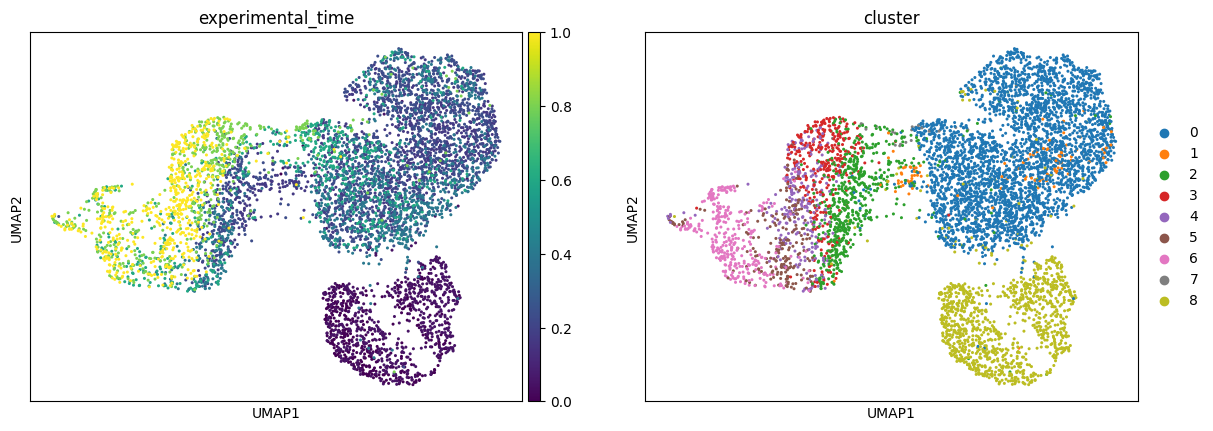

In [40]:
# sc.pl.umap(adata_vae_z, color=["experimental_time", "leiden"])
sc.pl.umap(adata_geometric_z, color=["experimental_time", "cluster"])

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


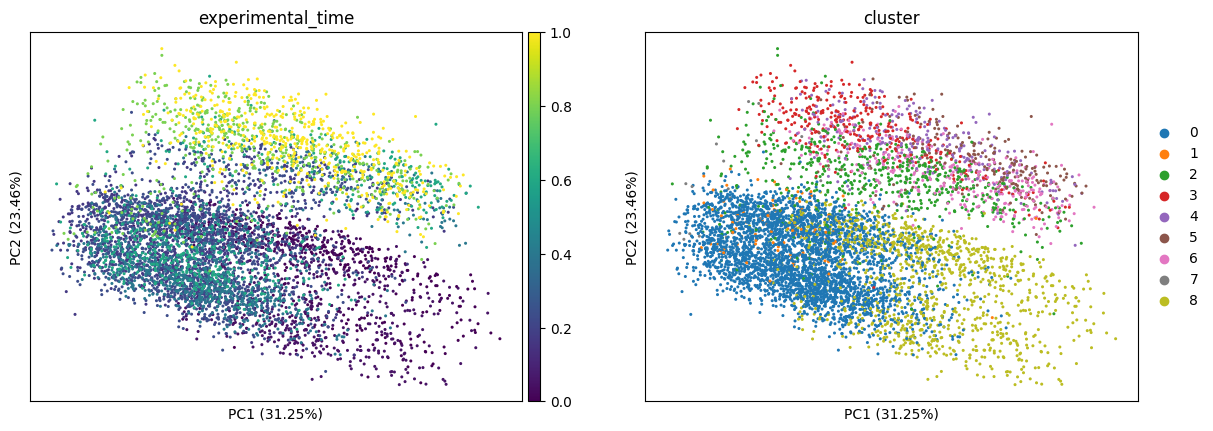

In [41]:
# sc.pl.pca(adata_vae_z, color=["experimental_time", "leiden"], annotate_var_explained=True)
sc.pl.pca(adata_geometric_z, color=["experimental_time", "cluster"], annotate_var_explained=True)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


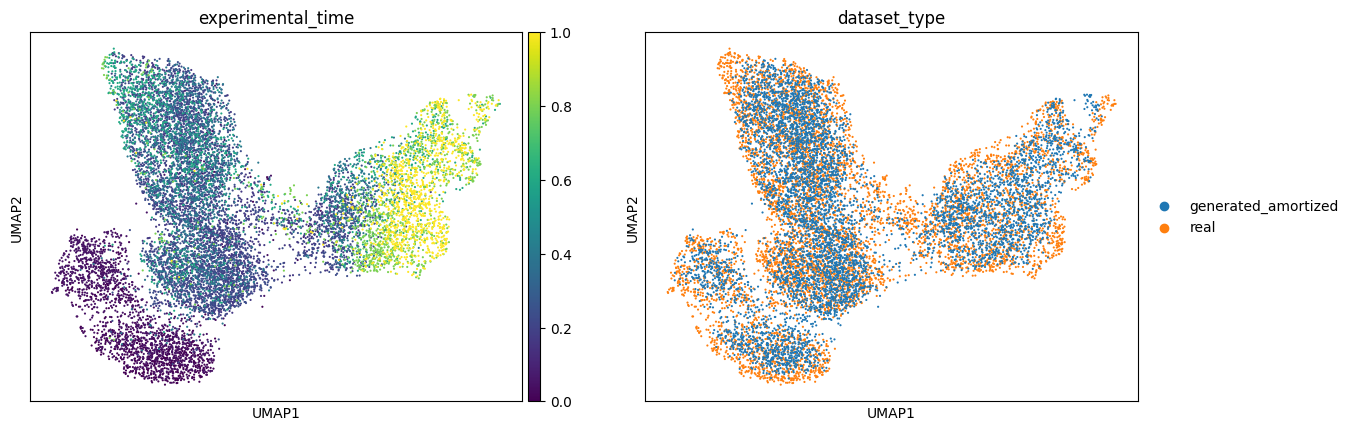

In [42]:
# sc.pl.umap(adata_vae_amortized_real, color=["experimental_time", "dataset_type"])
sc.pl.umap(adata_geometric_amortized_real, color=["experimental_time", "dataset_type"])

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


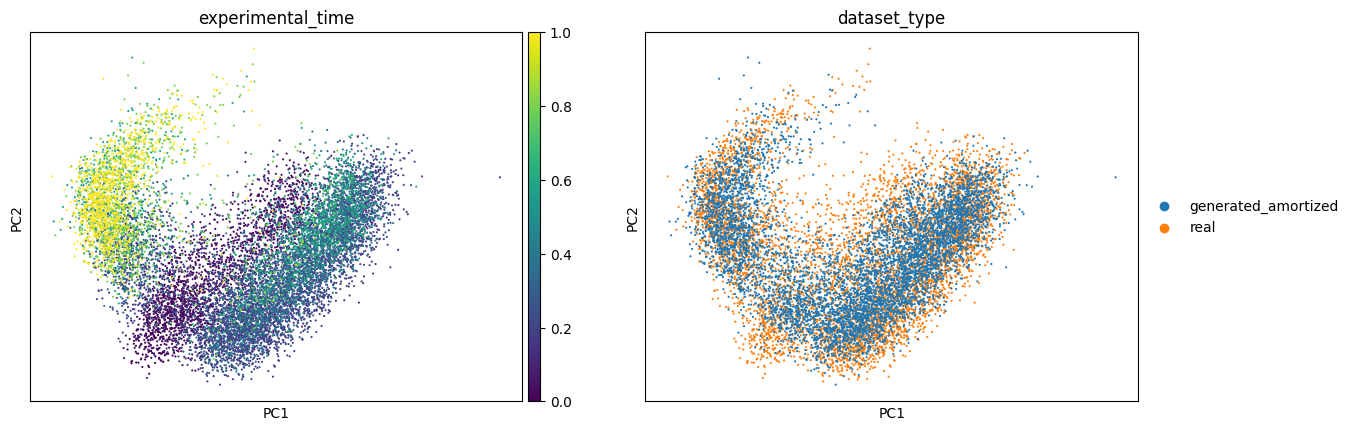

In [43]:
# sc.pl.pca(adata_vae_amortized_real, color=["experimental_time", "dataset_type"])
sc.pl.pca(adata_geometric_amortized_real, color=["experimental_time", "dataset_type"])

Check reconstruction umap

In [14]:
from pytorch_lightning import Trainer

# trainer_vae = Trainer(inference_mode=False)
trainer_geometric = Trainer(inference_mode=False)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-pa ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [80]:
# trainer_vae.validate(model=vae, dataloaders=datamodule)

In [81]:
# trainer_geometric.validate(model=geometric_vae, 
#                        dataloaders=datamodule)